In [1]:
import numpy as np
import tensorflow as tf
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import pandas as pd
import pandas_datareader.data as web
import fix_yahoo_finance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [4]:
def getData():
    # Grab 10 years of Apple and NASDAQ data.  
    # Note that the old Yahoo Finance API was deprecated.  (Thanks, Verizon!  That Marissa pay-out was steep.)
    # Ran Aroussi has developed a fix that saves accessibility to Yahoo Finance. Thanks, Ran! Great stuff. 
    start, end = "2006-01-01", "2015-12-31"
    aapl_all = web.get_data_yahoo("aapl", start=start, end=end)
    nasdaq_all = web.get_data_yahoo("^ixic", start=start, end=end)
    aapl = aapl_all['Adj Close']
    nasdaq = nasdaq_all['Adj Close']
    
    # Calculate daily returns.
    aapl_returns = np.log(aapl / aapl.shift(1))
    nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
    aapl_returns = aapl_returns.dropna()
    nasdaq_returns = nasdaq_returns.dropna()
    aapl_returns = pd.DataFrame(aapl_returns)
    nasdaq_returns = pd.DataFrame(nasdaq_returns)
    
    data = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)
    data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
    return data

data = getData()

In [5]:
class MLPModel:
    name = 'MLP'
    
    @staticmethod
    def create(layers=[500,1000,1000,1000,500]):
        model = Sequential()
        for u in layers:
            model.add(Dense(units=u, activation='relu', input_dim=1))
        model.add(Dense(units=1))
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        return model

    @staticmethod
    def prepareData(X, **kwargs):
        return X

class LSTMModel:
    name = 'LSTM'

    @staticmethod
    def create(blocks=4, look_back=1):
        shape = (1,look_back)
        model = Sequential()
        model.add(LSTM(blocks, input_shape=shape))
        model.add(Dense(units=1))
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        return model
    
    @staticmethod
    def createDataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    @staticmethod
    def prepareData(X, **kwargs):
        return X.reshape(X.shape[0], 1, 1)

In [6]:
def evalModel(data, 
              modelClass=MLPModel,
              modelParams={'layers': [500,1000,1000,1000,500]},
              epochs=20, batch_size=100,
              nIter=9, testSplit=0.2,
              xVar='nasdaq', yVar='aapl', 
              ):
    modelName = modelClass.name
    
    # Prep data
    datatrain, datatest = train_test_split(data, test_size = testSplit)
    trainX = datatrain[xVar].as_matrix()
    trainY = datatrain[yVar].as_matrix()
    testX = datatest[xVar].as_matrix()
    testY = datatest[yVar].as_matrix()
    datatest = datatest.copy()
    
    # Run OLS
    print ('Run OLS')
    startTime = time.time()
    minMSE = 1e30
    for i in range(nIter):
        print('Iteration %d/%d' % (i+1, nIter)),
        mod = smf.ols(formula='%s ~ %s' % (yVar, xVar), data = datatrain).fit()
        fitted = mod.predict(exog = datatest)
        mse = ((datatest['aapl'] - fitted)**2).mean()
        print('- the MSE is %f' % mse)

        if mse<minMSE:
            datatest['fitted'] = fitted
            minMSE = mse
    print ('The best MSE is %f' % minMSE)
    print ('The average running time is: %0.2f seconds' % ((time.time()-startTime)/nIter))
    print('')
    
    trainX = modelClass.prepareData(trainX, **modelParams)
    testX = modelClass.prepareData(testX, **modelParams)

    # Run model
    minMSE = 1e30
    print ('Run %s' % modelName)
    startTime = time.time()
    for i in range(nIter):
        print('Iteration %d/%d' % (i+1, nIter)),
        model = modelClass.create(**modelParams)
        #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
        model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
        target = model.predict(testX)
        colName = 'target %s' % i
        datatest[colName] = target
        mse = ((datatest[yVar] - datatest[colName])**2).mean()
        print('- the MSE is %f' % mse)

        if mse<minMSE:
            minMSE = mse
            datatest['target'] = target
            
    print ('The best MSE is %f' % minMSE)
    print ('The average running time is: %0.2f seconds' % ((time.time()-startTime)/nIter))

    # Visualization 1 - AAPL Return: Model vs. OLS
    fig, ax = plt.subplots(figsize=(15,6), dpi=300)
    series = [yVar, 'fitted', 'target']
    tdata = [datatest[series].values]
    ax = sns.tsplot(data=tdata, legend=True, time=datatest.axes[0])
    ax.legend(handles=ax.lines, labels=[yVar.upper(), 'OLS', modelName], prop={'size': 14})
    #ax = sns.tsplot(data=tdata, condition='Series', value='Value', time='Date')
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: pd.to_datetime(x).strftime('%Y-%m-%d')))
    plt.ylabel('%s Return' % (yVar.upper(),))
    fig.autofmt_xdate()
    
    # Visualization 2 - Squared Error: Model vs. OLS
    fig, ax = plt.subplots(figsize=(15,6), dpi=300)
    tdata = np.dstack([((datatest['fitted']-datatest[yVar])**2).values, 
                       ((datatest['target']-datatest[yVar])**2).values])
    ax = sns.tsplot(data=tdata, legend=True, time=datatest.axes[0])
    ax.legend(handles=ax.lines, labels=['OLS', modelName], prop={'size': 14})
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: pd.to_datetime(x).strftime('%Y-%m-%d')))
    plt.ylabel('Squared Error (SE)')
    fig.autofmt_xdate()

    # Visualization 3 - Difference in SE between Model and OLS
    fig, ax = plt.subplots(figsize=(15,6), dpi=300)
    tdata = [(((datatest['target']-datatest[yVar])**2)-
              ((datatest['fitted']-datatest[yVar])**2)).values]
    ax = sns.tsplot(data=tdata, legend=True, time=datatest.axes[0])
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: pd.to_datetime(x).strftime('%Y-%m-%d')))
    plt.ylabel('Difference in SE')
    fig.autofmt_xdate()

Run OLS
Iteration 1/9 - the MSE is 0.000197
Iteration 2/9 - the MSE is 0.000197
Iteration 3/9 - the MSE is 0.000197
Iteration 4/9 - the MSE is 0.000197
Iteration 5/9 - the MSE is 0.000197
Iteration 6/9 - the MSE is 0.000197
Iteration 7/9 - the MSE is 0.000197
Iteration 8/9 - the MSE is 0.000197
Iteration 9/9 - the MSE is 0.000197
The best MSE is 0.000197
The average running time is: 0.01 seconds

Run MLP
Iteration 1/9 - the MSE is 0.000216
Iteration 2/9 - the MSE is 0.000210
Iteration 3/9 - the MSE is 0.000221
Iteration 4/9 - the MSE is 0.000206
Iteration 5/9 - the MSE is 0.000206
Iteration 6/9 - the MSE is 0.000205
Iteration 7/9 - the MSE is 0.000204
Iteration 8/9 - the MSE is 0.000208
Iteration 9/9 - the MSE is 0.000204
The best MSE is 0.000204
The average running time is: 10.26 seconds


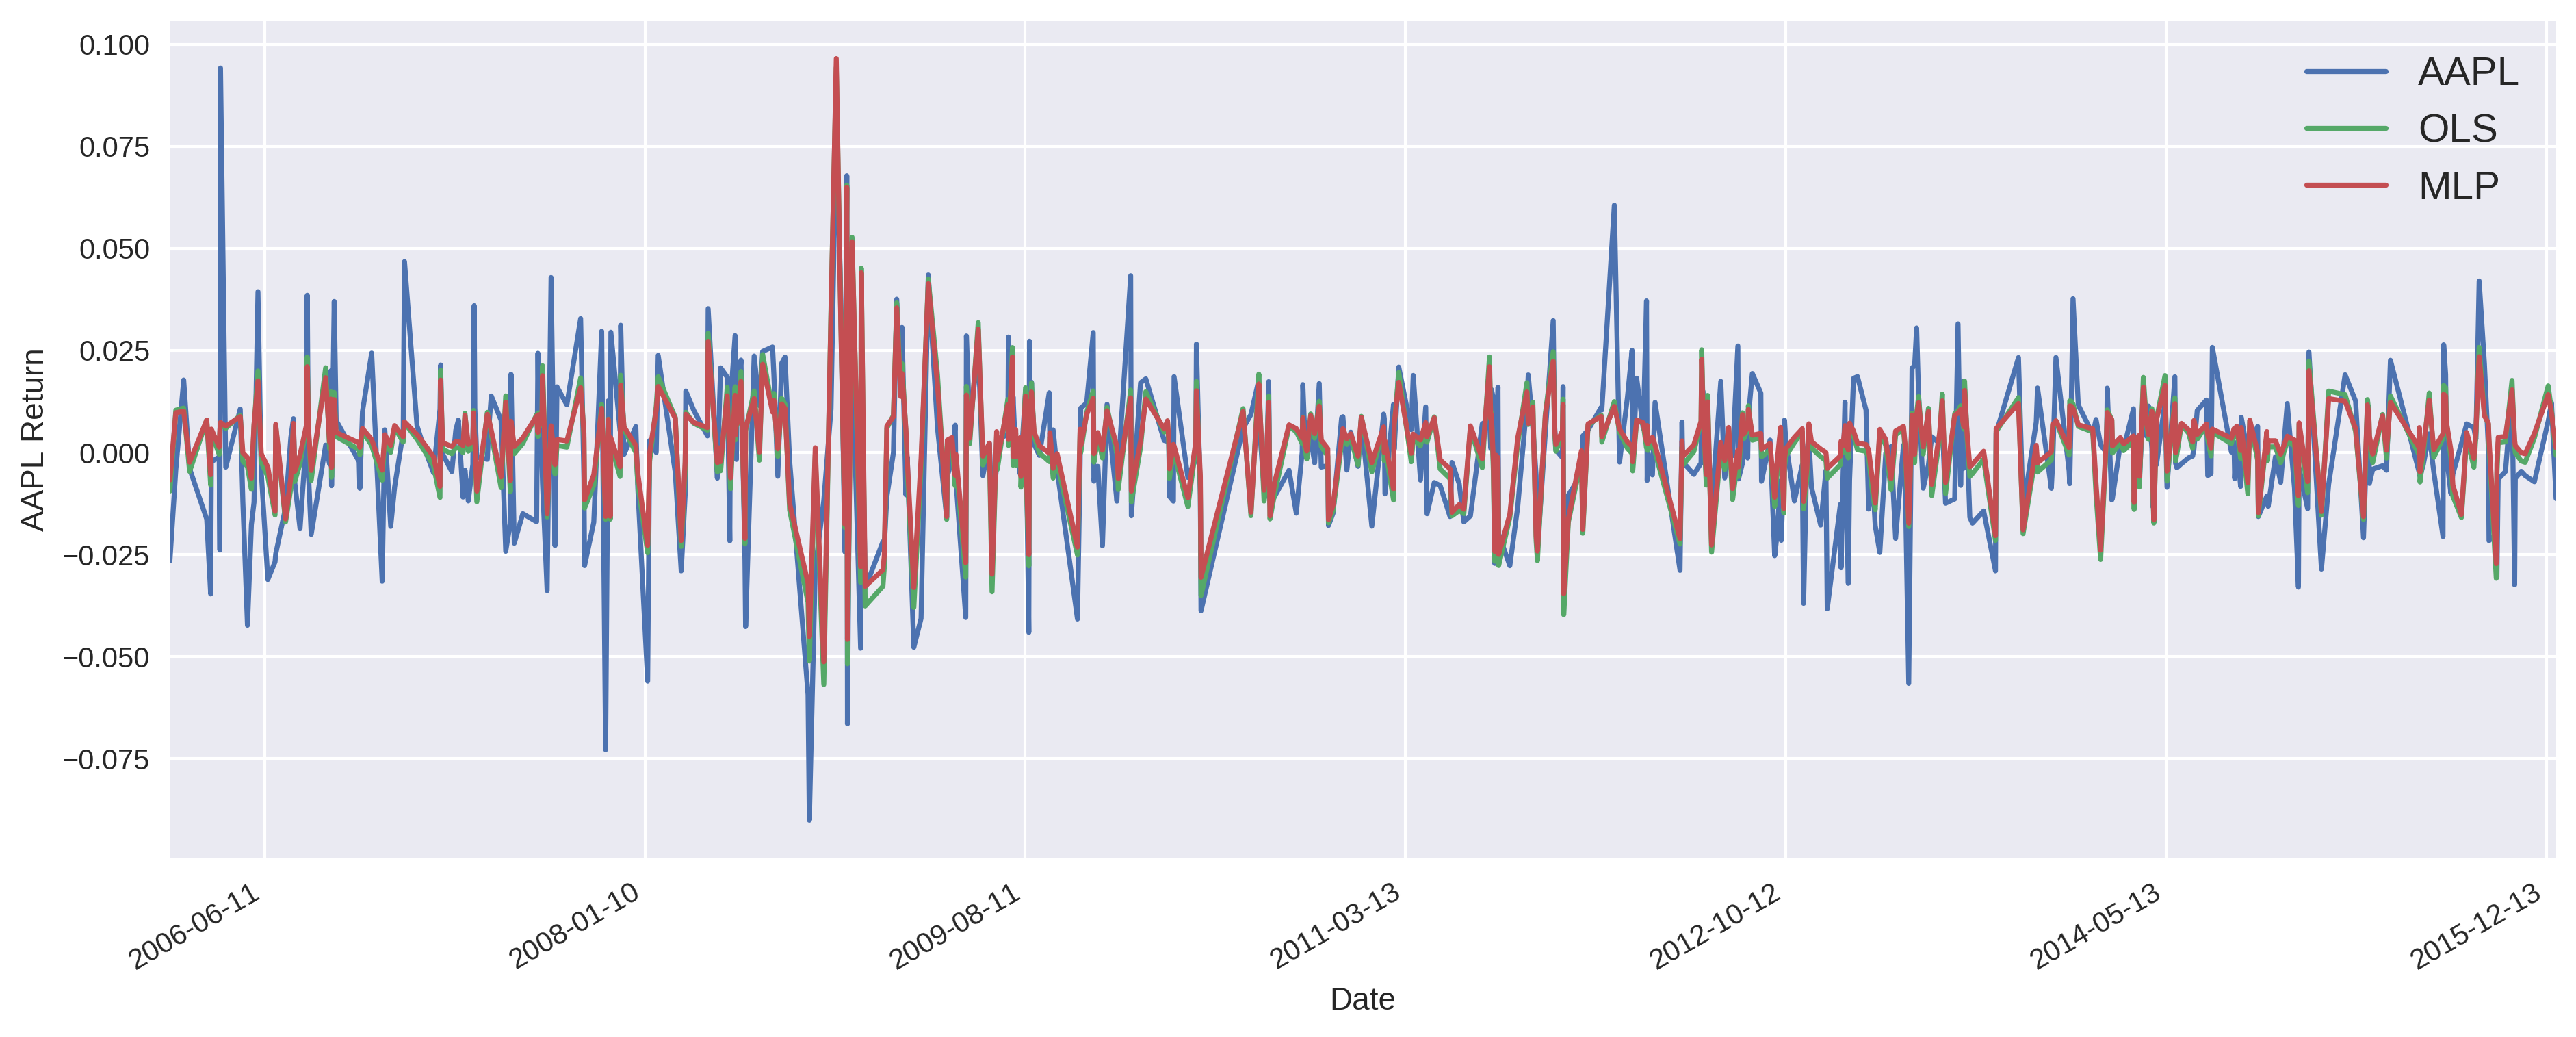

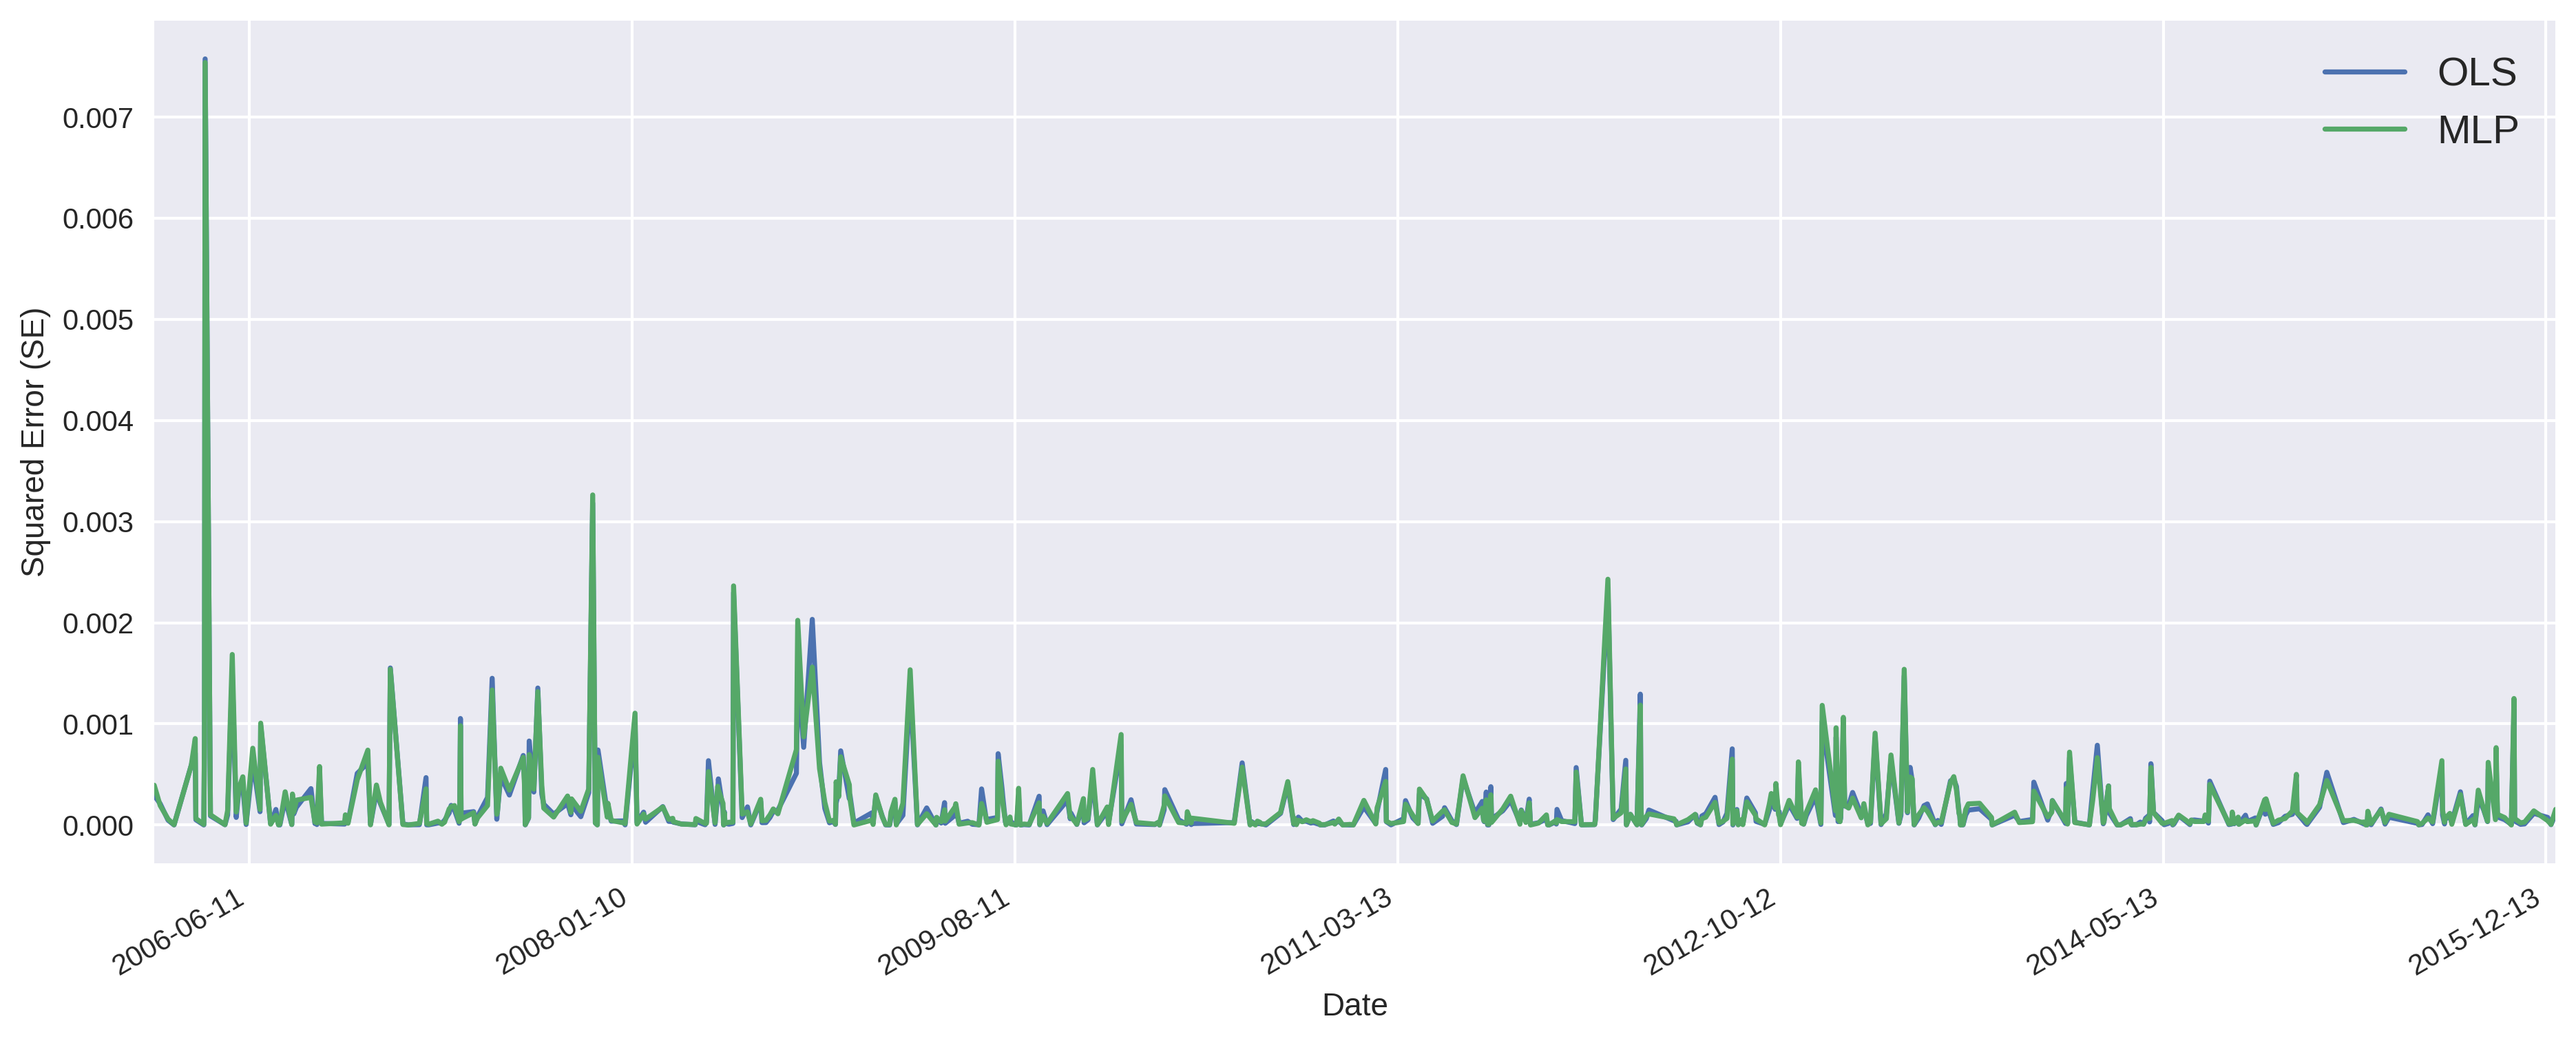

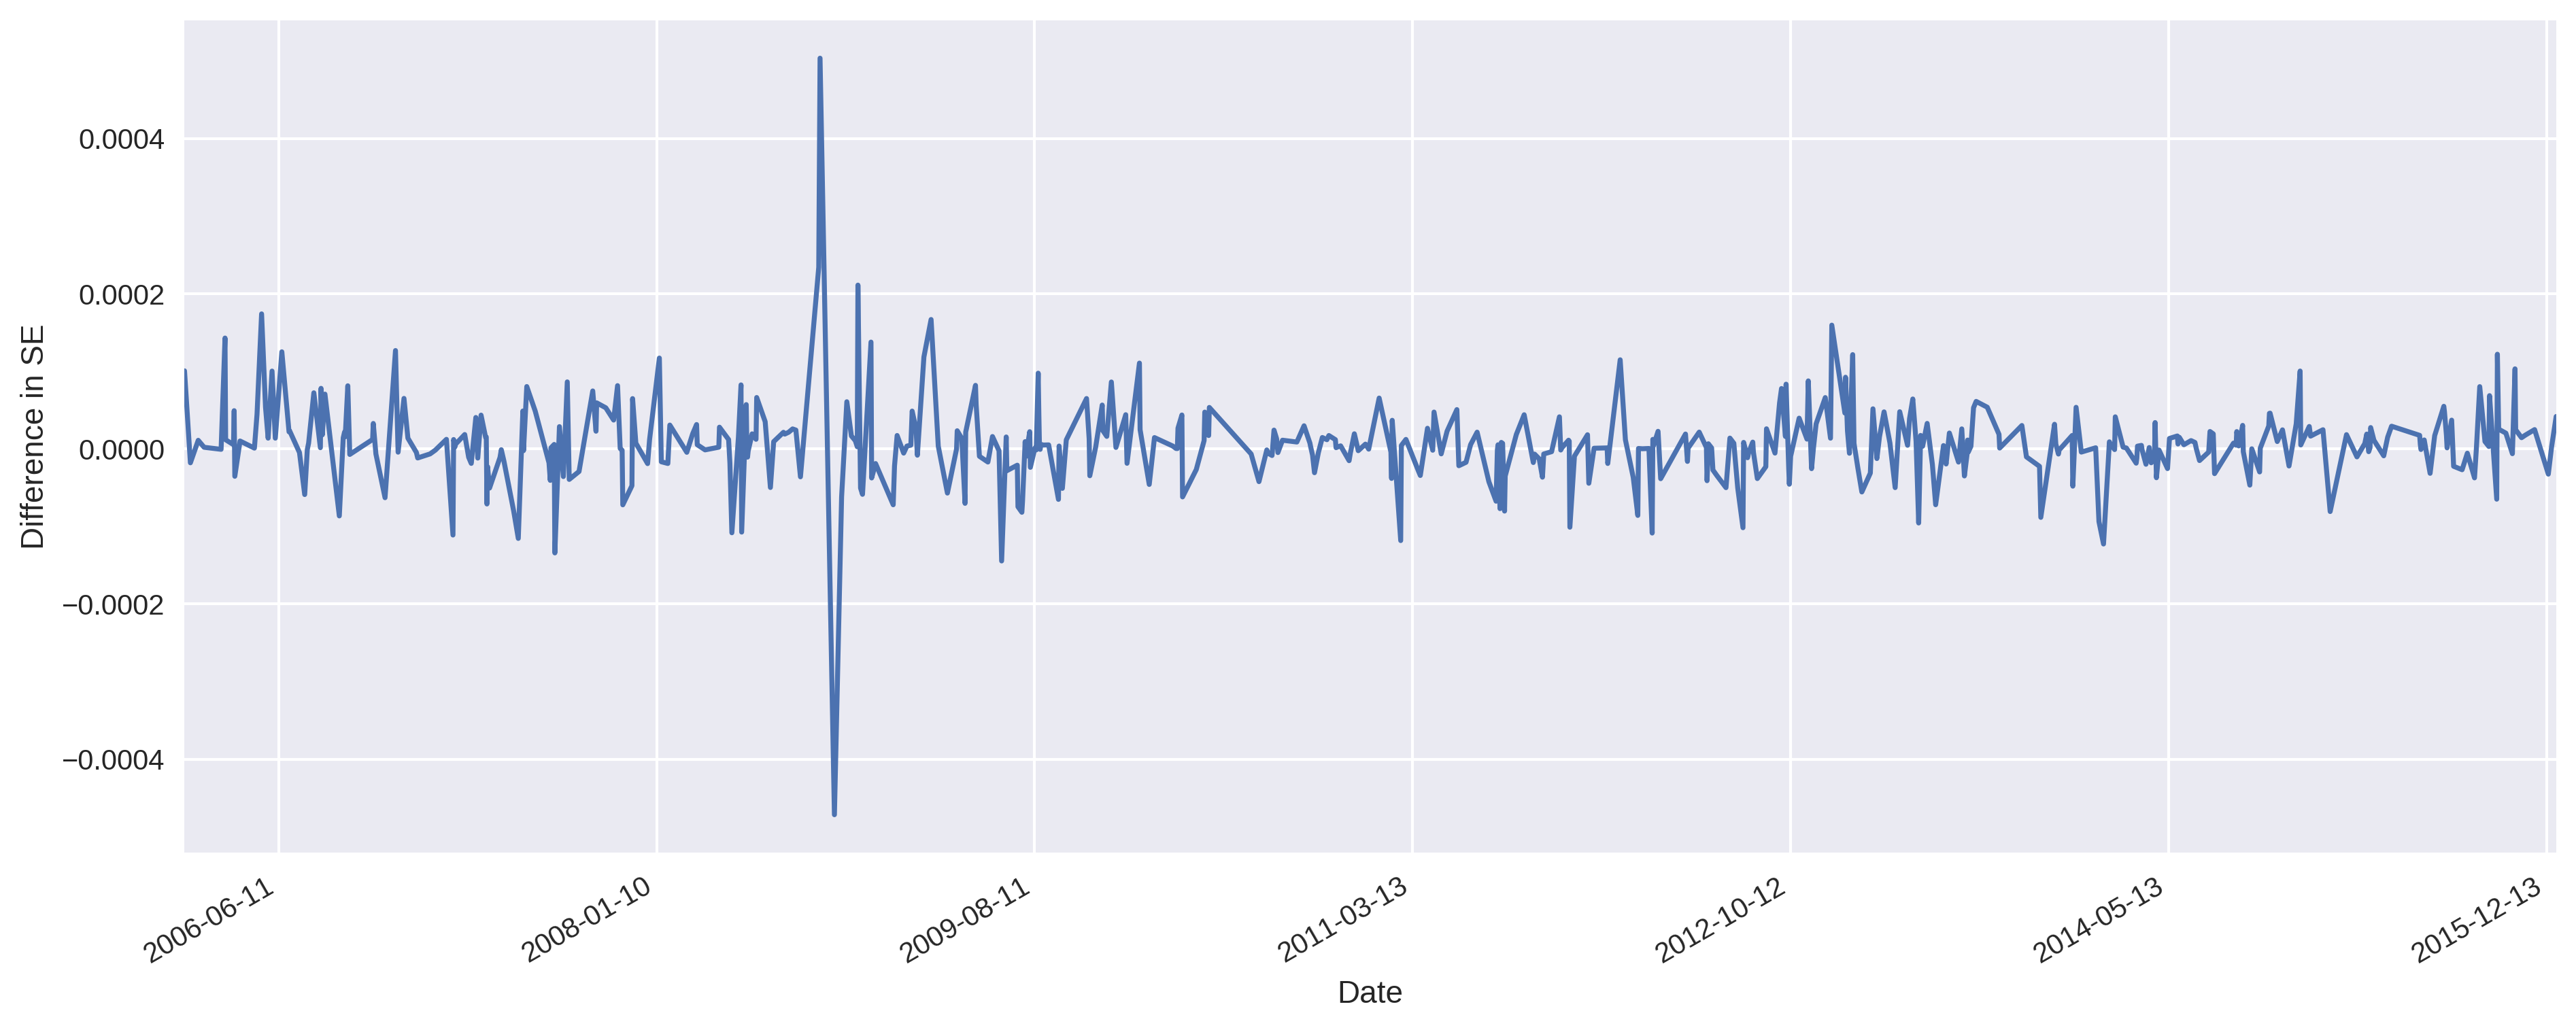

In [7]:
with tf.device('/cpu:0'):
    evalModel(data, nIter=9,
              modelClass=MLPModel,
              modelParams={'layers': [500,1000,1000,1000,500]},
              epochs=20, batch_size=100,
              xVar='nasdaq', yVar='aapl')


Run OLS
Iteration 1/5 - the MSE is 0.000263
Iteration 2/5 - the MSE is 0.000263
Iteration 3/5 - the MSE is 0.000263
Iteration 4/5 - the MSE is 0.000263
Iteration 5/5 - the MSE is 0.000263
The best MSE is 0.000263
The average running time is: 0.01 seconds

Run LSTM
Iteration 1/5 - the MSE is 0.000301
Iteration 2/5 - the MSE is 0.000263
Iteration 3/5 - the MSE is 0.000267
Iteration 4/5 - the MSE is 0.000267
Iteration 5/5 - the MSE is 0.000289
The best MSE is 0.000263
The average running time is: 100.30 seconds


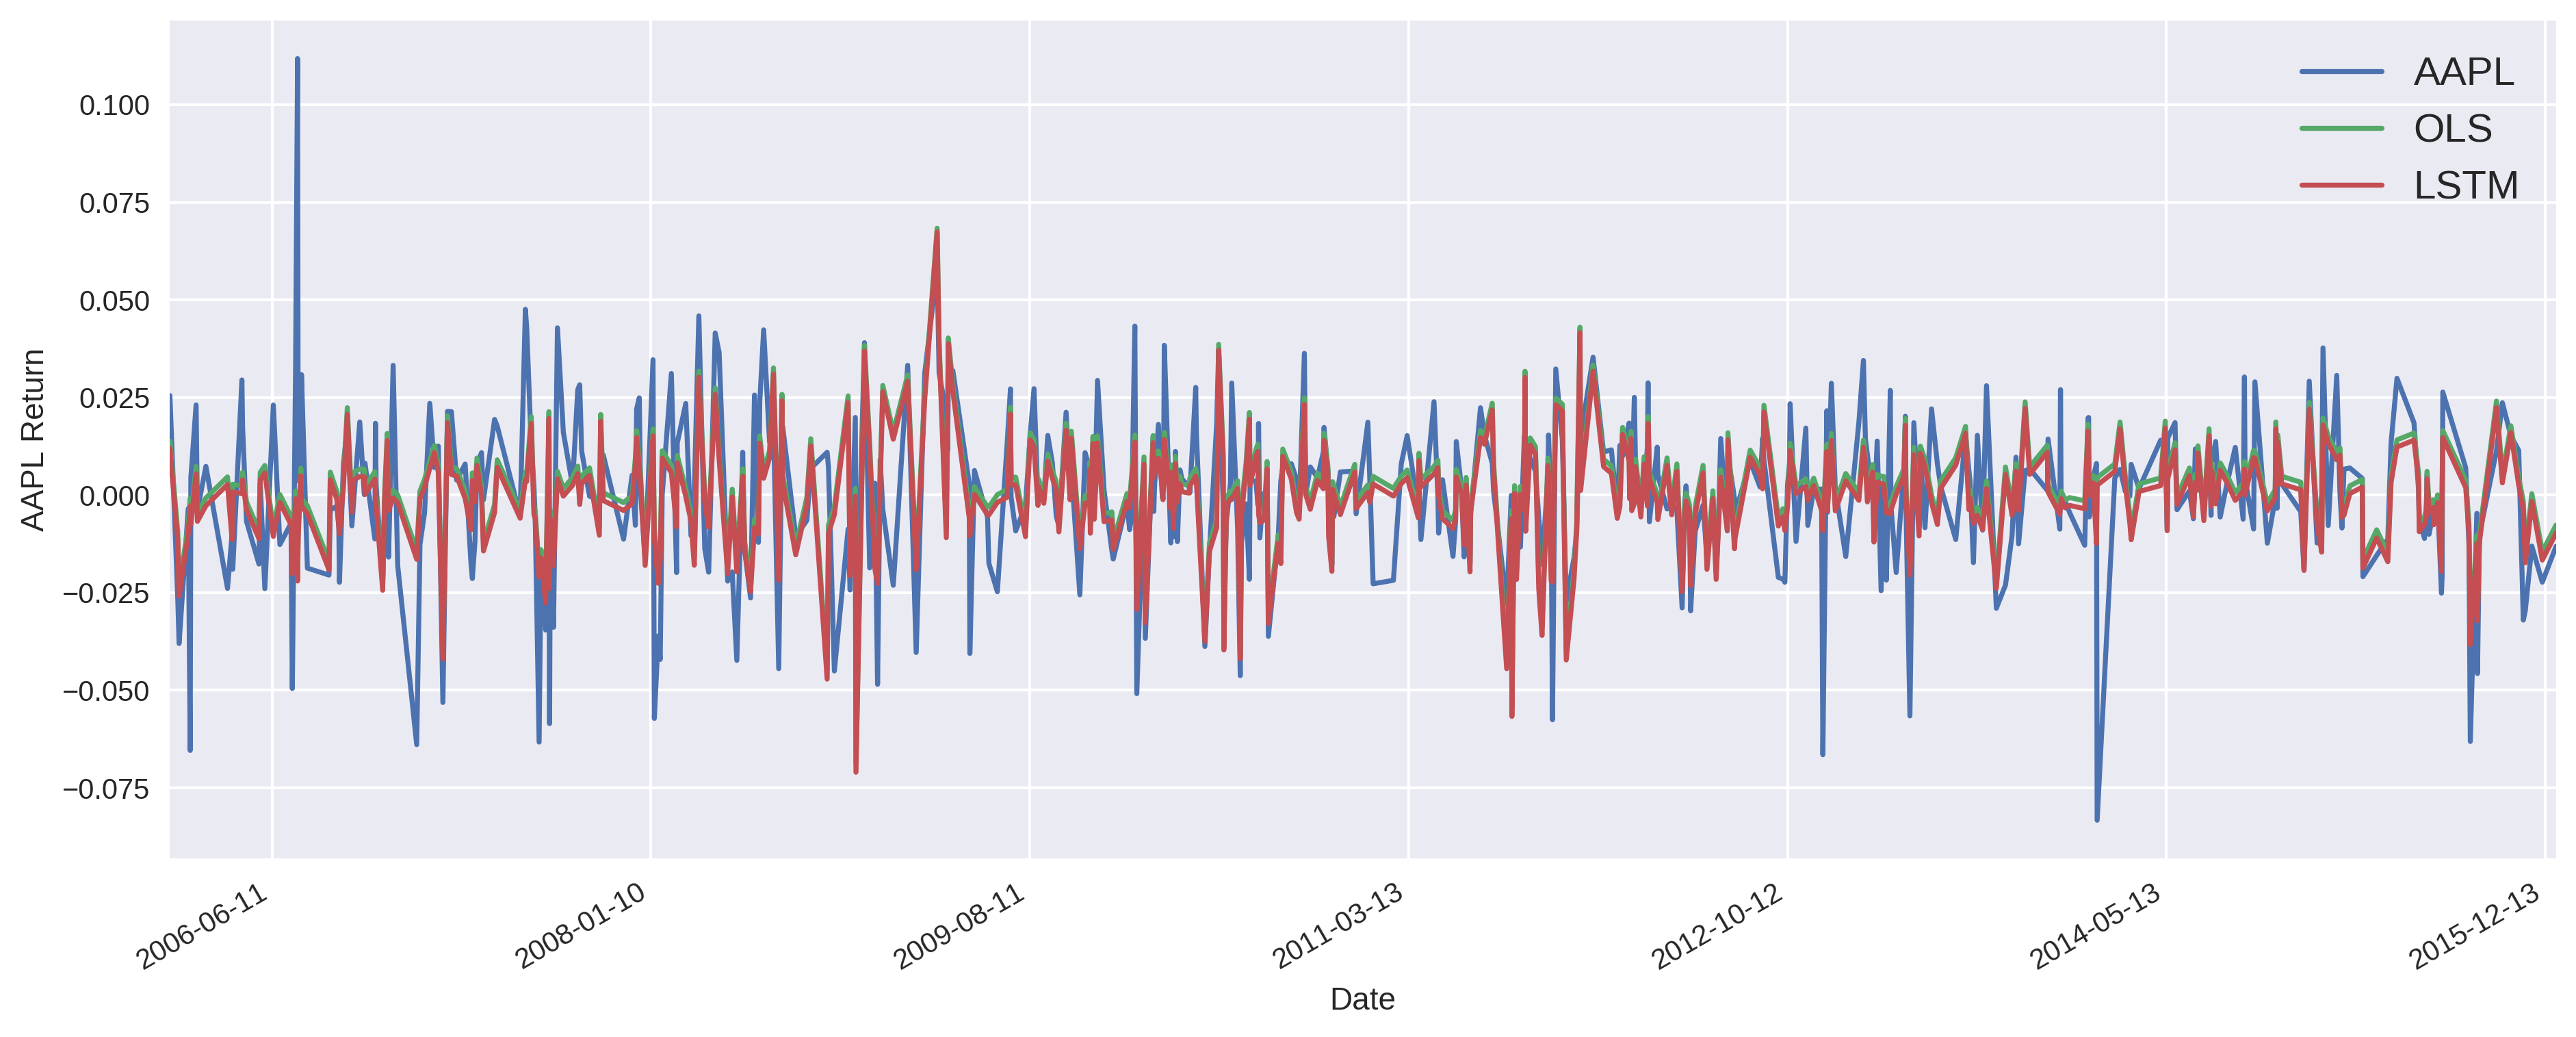

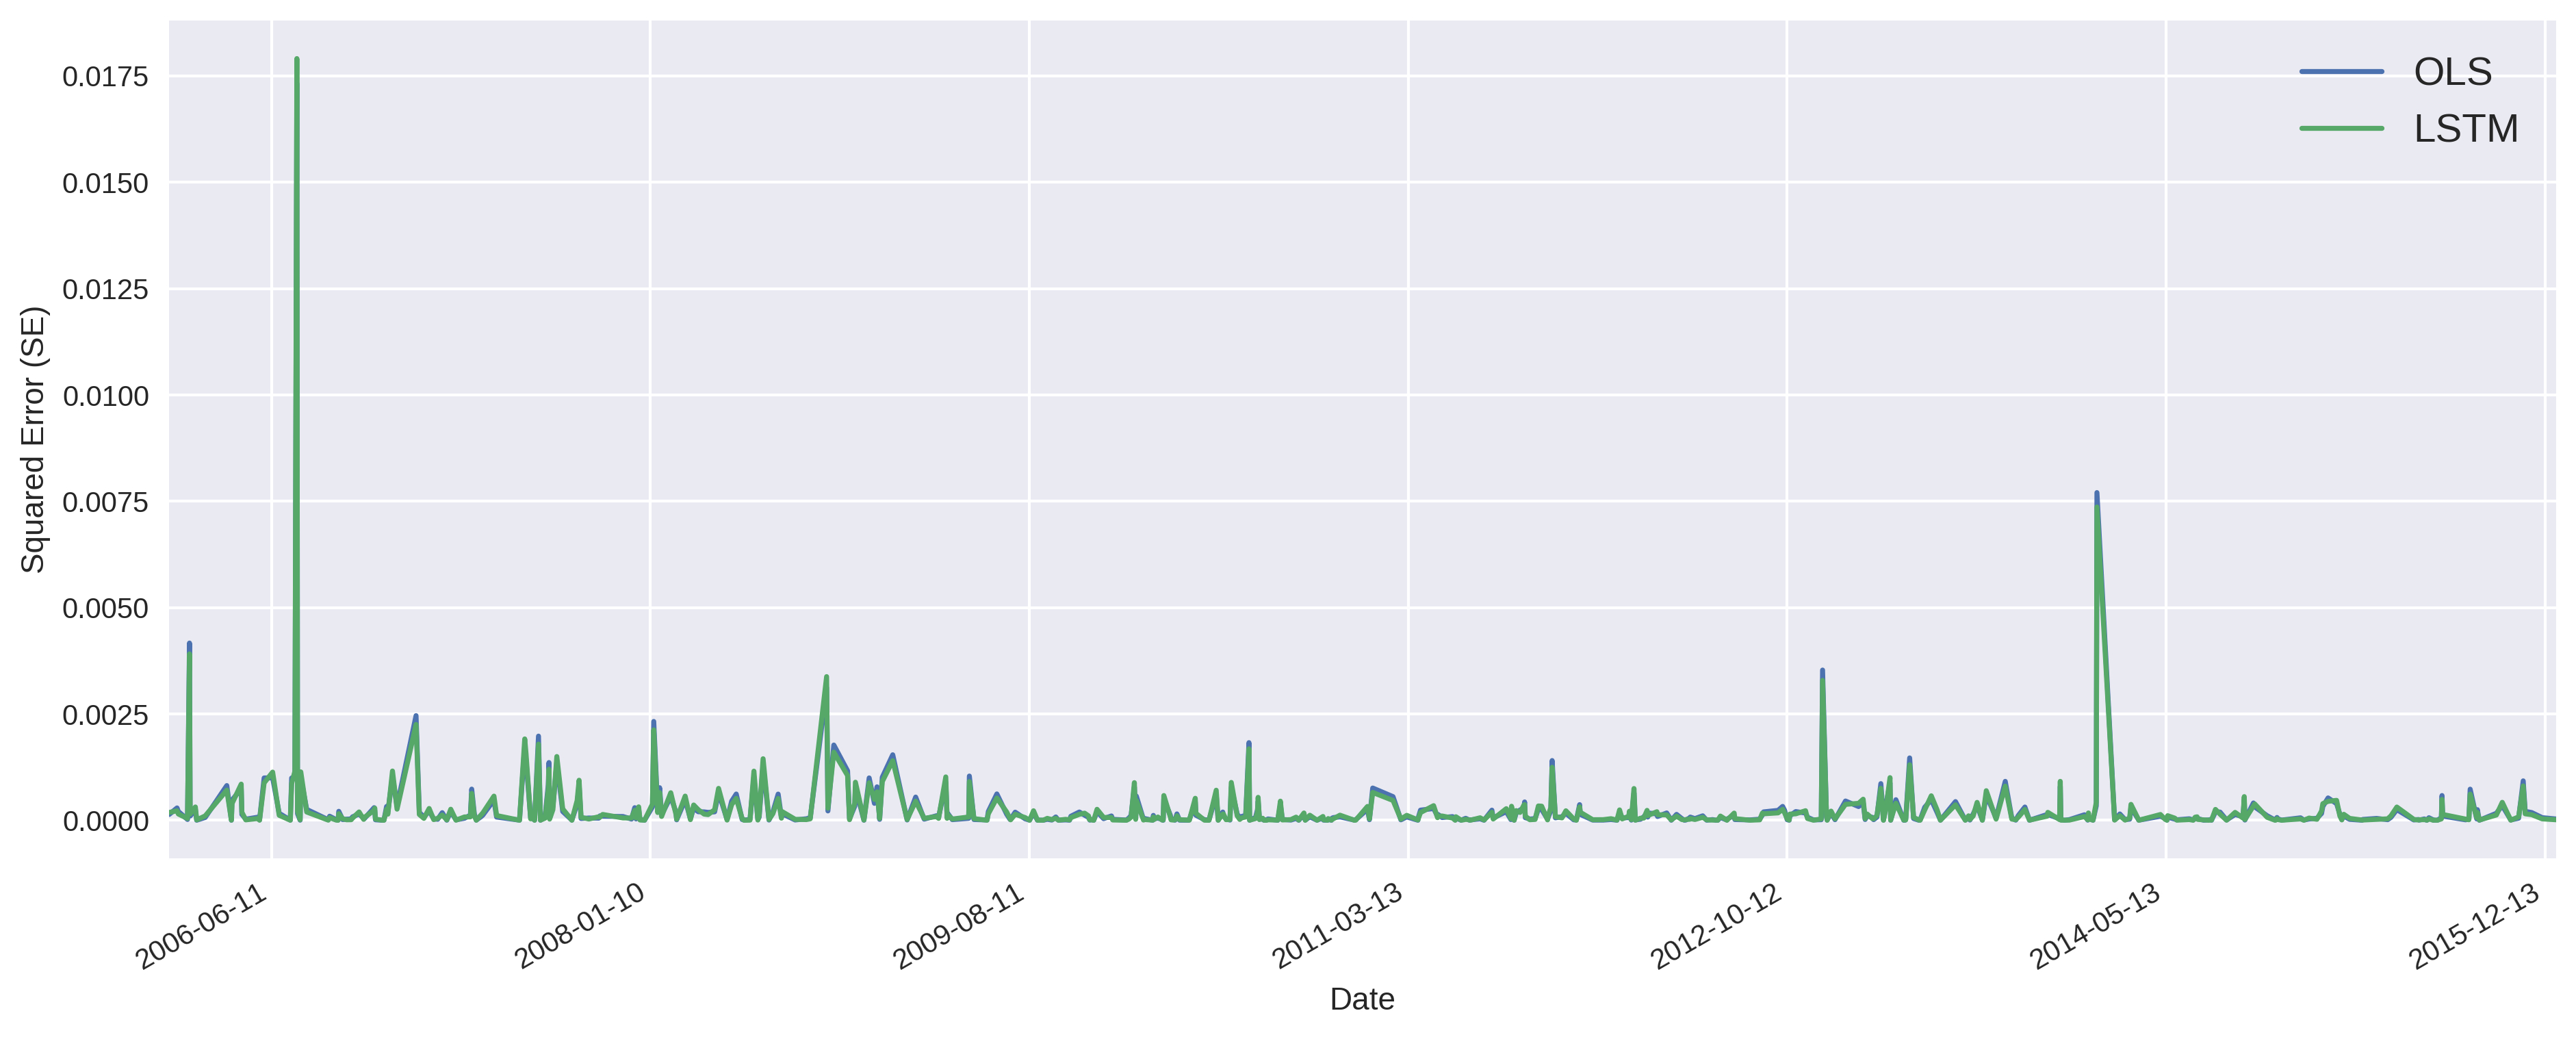

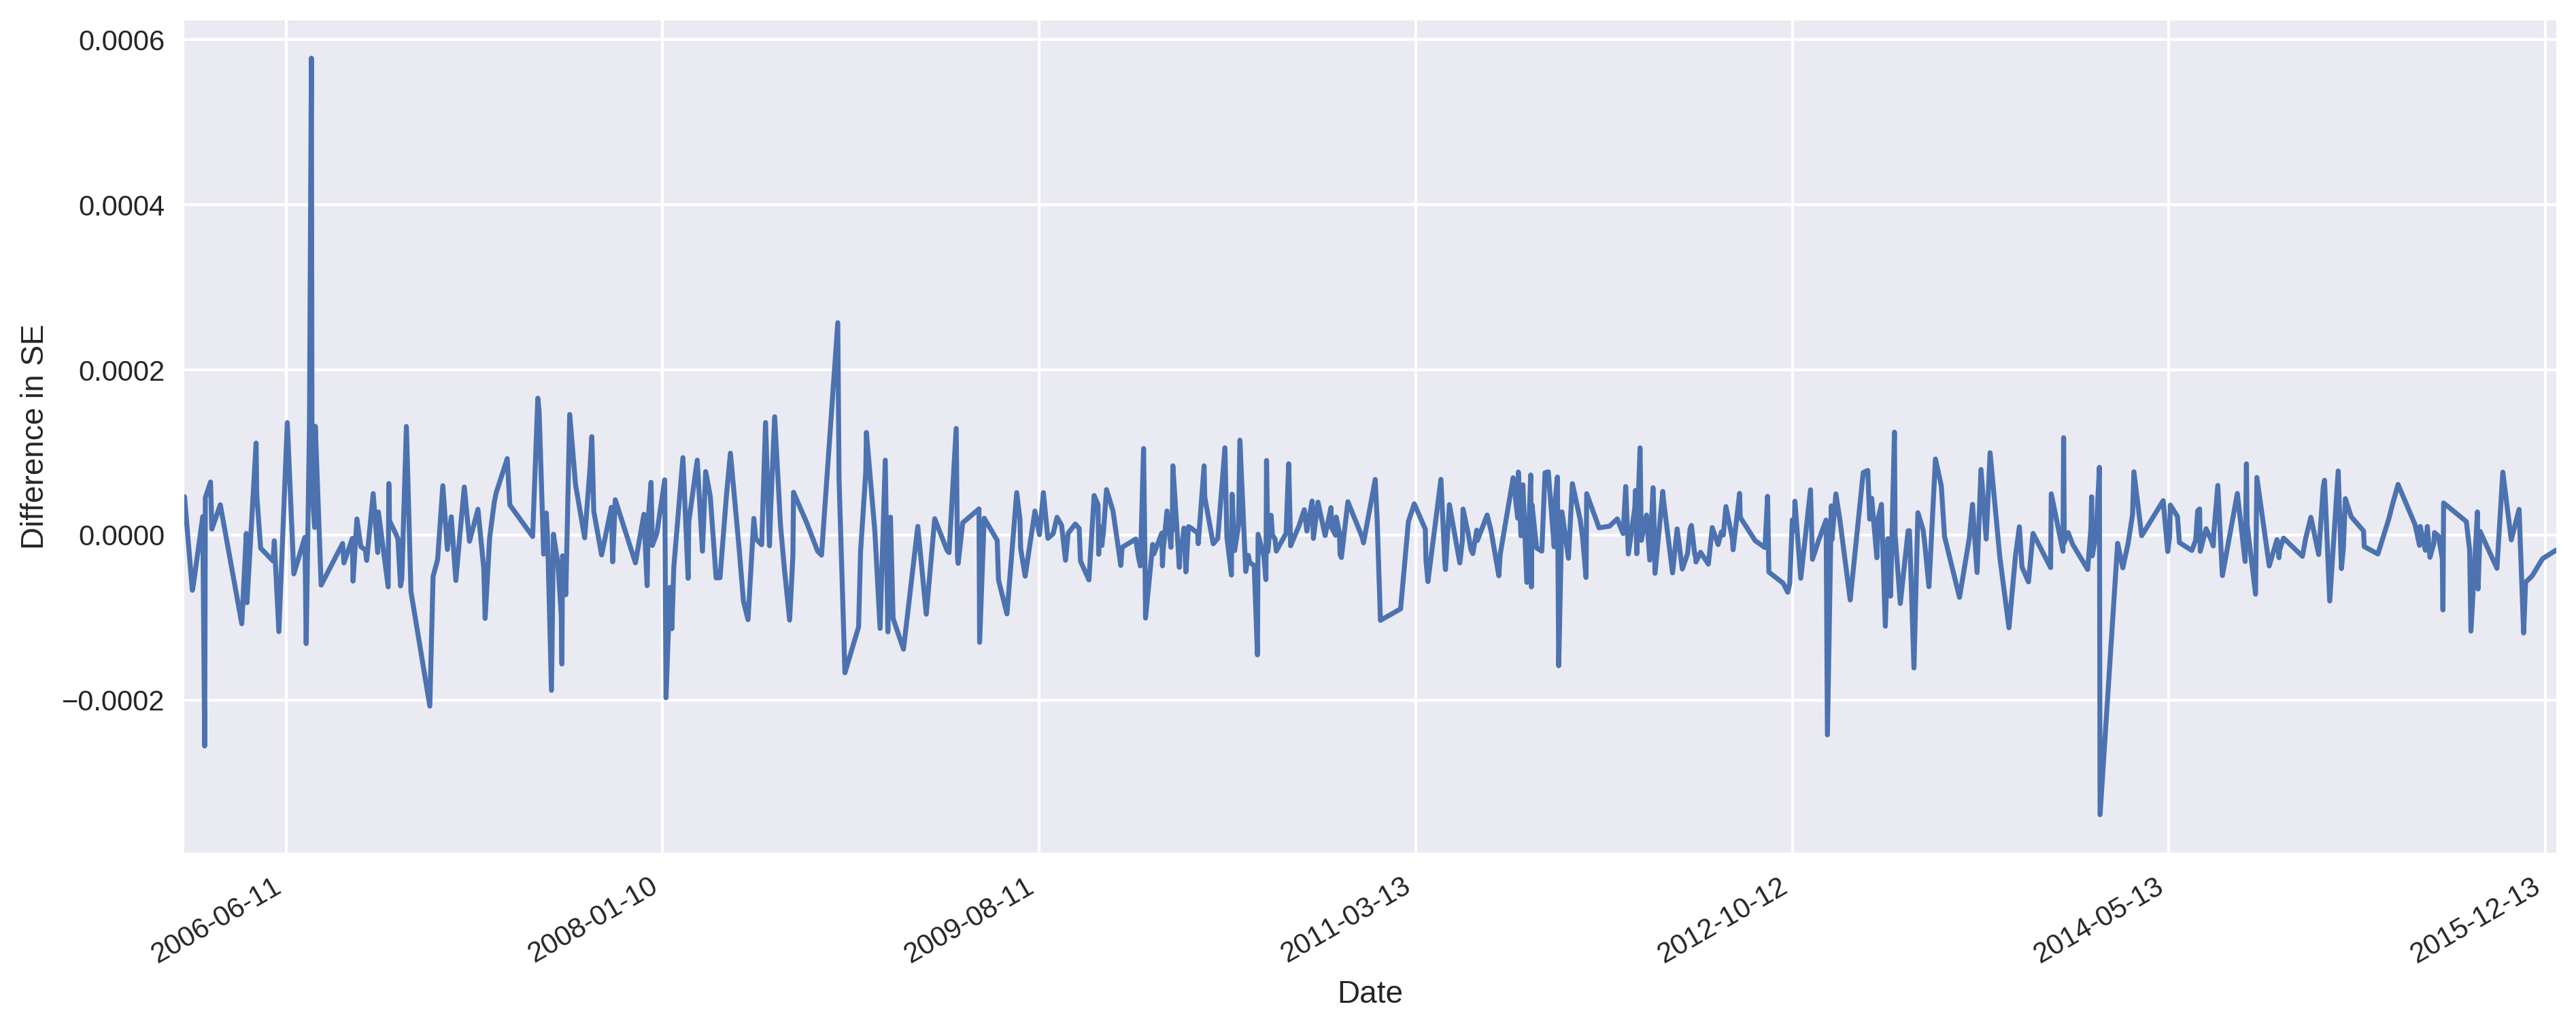

In [8]:
with tf.device('/cpu:0'):
    evalModel(data, nIter=5,
              modelClass=LSTMModel,
              modelParams={'blocks': 10, 'look_back': 1},
              epochs=10, batch_size=1,
              xVar='nasdaq', yVar='aapl')